In [23]:
from imageio import imread
import os
from skimage.transform import resize
import cv2
import numpy as np
import pandas as pd

In [24]:
def load_and_flatten_image(imagePath, width, height):
    image = imread(imagePath)
    #small_image = resize(image, (11, 20))
    image_single_channel = image[:,:,0]
    small_image = cv2.resize(image_single_channel, (width, height))
    #small_image = image_single_channel
    image_array = small_image.flatten()
    return image_array

In [25]:
path = "classificatie"
width = 40
height = 22
cpt = sum([len(files) for r, d, files in os.walk(path)])
data_array = np.empty([cpt, height*width], dtype=np.uint8)
label_array = np.empty([cpt], dtype=np.str_)
counter = 0
for root, dirs, files in os.walk(path):
    for dirname in dirs:
        for root2, dirs2, files2 in os.walk(os.path.join(path, dirname)):
            for filename in files2:
                image = load_and_flatten_image(os.path.join(os.path.join(path, dirname), filename), width, height)
                for key, pixel in enumerate(image):
                    data_array[counter][key] = pixel
                label_array[counter] = dirname
                counter += 1

dataset = pd.DataFrame({'label': label_array, 'images': list(data_array)}, columns=['label', 'images'])
dataset.head()

,label,images
0,a,"[181, 115, 131, 138, 133, 125, 112, 95, 95, 17..."
1,a,"[180, 120, 131, 139, 133, 126, 110, 94, 98, 16..."
2,a,"[183, 110, 115, 112, 108, 112, 106, 94, 93, 20..."
3,a,"[184, 115, 118, 120, 113, 114, 111, 96, 95, 20..."
4,a,"[180, 113, 117, 113, 113, 112, 108, 93, 94, 20..."


In [26]:
for index in range(len(dataset)):
    int_value = "1" if dataset.loc[index,"label"] == "a" else "2" if dataset.loc[index,"label"] == "b" else "3"
    dataset.loc[index,"label"] = int_value
dataset.head()

,label,images
0,1,"[181, 115, 131, 138, 133, 125, 112, 95, 95, 17..."
1,1,"[180, 120, 131, 139, 133, 126, 110, 94, 98, 16..."
2,1,"[183, 110, 115, 112, 108, 112, 106, 94, 93, 20..."
3,1,"[184, 115, 118, 120, 113, 114, 111, 96, 95, 20..."
4,1,"[180, 113, 117, 113, 113, 112, 108, 93, 94, 20..."


In [27]:
dataset.label = dataset.label.astype(np.uint8)

In [28]:
dataset.label.info

<bound method Series.info of 0       1
1       1
2       1
3       1
4       1
       ..
2635    3
2636    3
2637    3
2638    3
2639    3
Name: label, Length: 2640, dtype: uint8>

In [29]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
tel = 0
for train_index, test_index in split.split(dataset, dataset["label"]):
    tel += 1
    print(tel)
    strat_train_set = dataset.loc[train_index]
    strat_test_set = dataset.loc[test_index]

1


In [30]:
X_train, y_train = strat_train_set["images"], strat_train_set["label"]

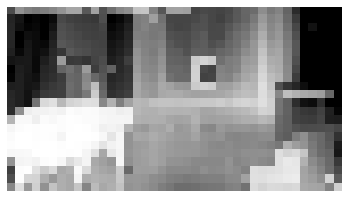

In [31]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
image = X_train[0]


some_digit_image = image.reshape(height, width)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

plt.show()


In [32]:
X_train.describe()

count                                                  2112
unique                                                 2112
top       [168, 88, 99, 97, 84, 93, 95, 101, 100, 171, 9...
freq                                                      1
Name: images, dtype: object

In [33]:
y_train.describe()

count    2112.000000
mean        2.206913
std         0.900176
min         1.000000
25%         1.000000
50%         3.000000
75%         3.000000
max         3.000000
Name: label, dtype: float64

In [34]:
X_train_array = X_train.to_numpy()
X_train_array_exploded = np.zeros((len(X_train_array),width*height))
for idx, x in np.ndenumerate(X_train_array):
    for idy, y in np.ndenumerate(x):
        X_train_array_exploded[idx][idy] = y
X_train_array_exploded

array([[168.,  88.,  99., ..., 190., 157.,  98.],
       [165.,  91.,  96., ..., 185., 156.,  97.],
       [172.,  98., 108., ..., 140., 161.,  97.],
       ...,
       [180., 110., 122., ..., 123., 126.,  67.],
       [168.,  88.,  90., ..., 187., 149.,  98.],
       [163.,  77.,  89., ..., 168., 135.,  98.]])

In [35]:
y_train_array = y_train.to_numpy()
y_train_array

array([1, 1, 3, ..., 2, 3, 3], dtype=uint8)

In [36]:


'''from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train_array_exploded, y_train_n_array)'''
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train_array_exploded, y_train_array)

SGDClassifier(random_state=42)

CROSS-VALIDATION

In [37]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train_array_exploded, y_train_array, cv=3, scoring="accuracy")

array([0.89914773, 0.87926136, 0.89204545])

In [38]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train_array_exploded, y_train_array)

RandomForestClassifier(random_state=42)

In [39]:
cross_val_score(forest_clf, X_train_array_exploded, y_train_array, cv=3, scoring="accuracy")

array([0.93465909, 0.94034091, 0.94460227])

In [40]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train_array_exploded, y_train_array)

SVC()

In [41]:
cross_val_score(svm_clf, X_train_array_exploded, y_train_array, cv=3, scoring="accuracy")

array([0.90909091, 0.90767045, 0.91477273])

CONFUSION-MATRIX

In [19]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train_array_exploded, y_train_array, cv=3)

In [20]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_array, y_train_pred)

array([[1157,  273],
       [ 206,  476]], dtype=int64)

In [21]:
y_train_pred = cross_val_predict(forest_clf, X_train_array_exploded, y_train_array, cv=3)

In [22]:
confusion_matrix(y_train_array, y_train_pred)

array([[1392,   38],
       [  84,  598]], dtype=int64)

In [ ]:
y_train_pred = cross_val_predict(svm_clf, X_train_array_exploded, y_train_array, cv=3)

In [ ]:
confusion_matrix(y_train_array, y_train_pred)